In [3]:
#Importing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import sys,os

In [20]:
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

# Load the Data and Make Transformations

In [5]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [11]:
from file import FileHandler

In [12]:
file_handler= FileHandler()

In [22]:
train_sales = file_handler.read_csv('../data/train.csv')

In [24]:
scaler = MinMaxScaler()
data = train_sales.groupby("Date").agg({"Sales": "mean"})
data

,Sales
Date,
2013-01-01,87.284560
2013-01-02,6233.030493
2013-01-03,5693.112108
2013-01-04,5954.218834
2013-01-05,5337.751570
...,...
2015-07-27,9602.952466
2015-07-28,8174.953363
2015-07-29,7623.284305


In [25]:
scaler.fit(data.Sales.values.reshape([-1, 1]))
dataScaled = scaler.transform(data.Sales.values.reshape(-1, 1))
data['DataScaled'] = dataScaled
data.tail(10)

,Sales,DataScaled
Date,,
2015-07-22,5480.168610,0.387284
2015-07-23,5997.370404,0.424427
2015-07-24,5920.470852,0.418904
2015-07-25,5400.597309,0.381570
2015-07-26,256.381166,0.012143
2015-07-27,9602.952466,0.683358
2015-07-28,8174.953363,0.580808
2015-07-29,7623.284305,0.541190
2015-07-30,7891.348879,0.560441


In [26]:
data.describe()

,Sales,DataScaled
count,942.000000,942.000000
mean,5782.702036,0.409011
std,2888.462029,0.207432
min,87.284560,0.000000
25%,5321.408512,0.375883
50%,6036.153617,0.427212
75%,7530.909865,0.534556
max,14012.150673,1.000000


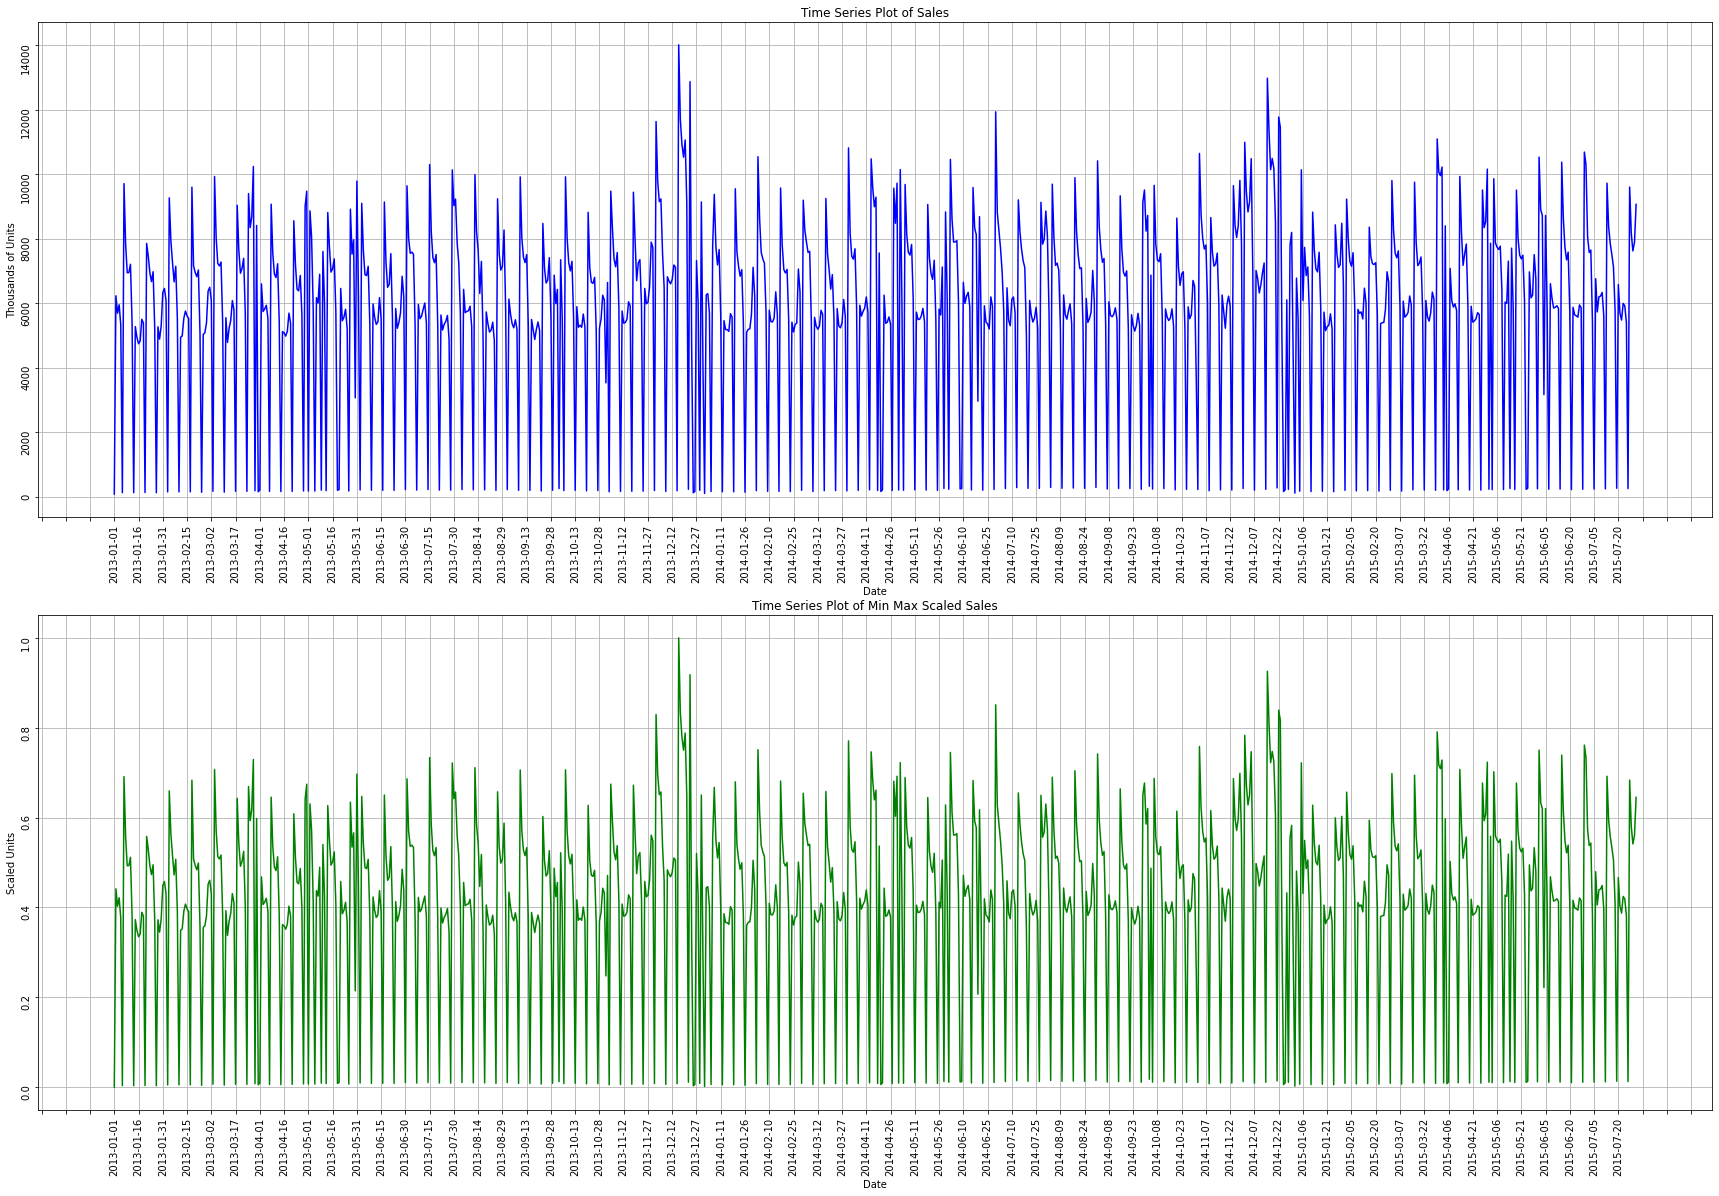

In [30]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(data.index, data.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(data.index, data.DataScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Sales')
ax2.grid(True)
plt.show()

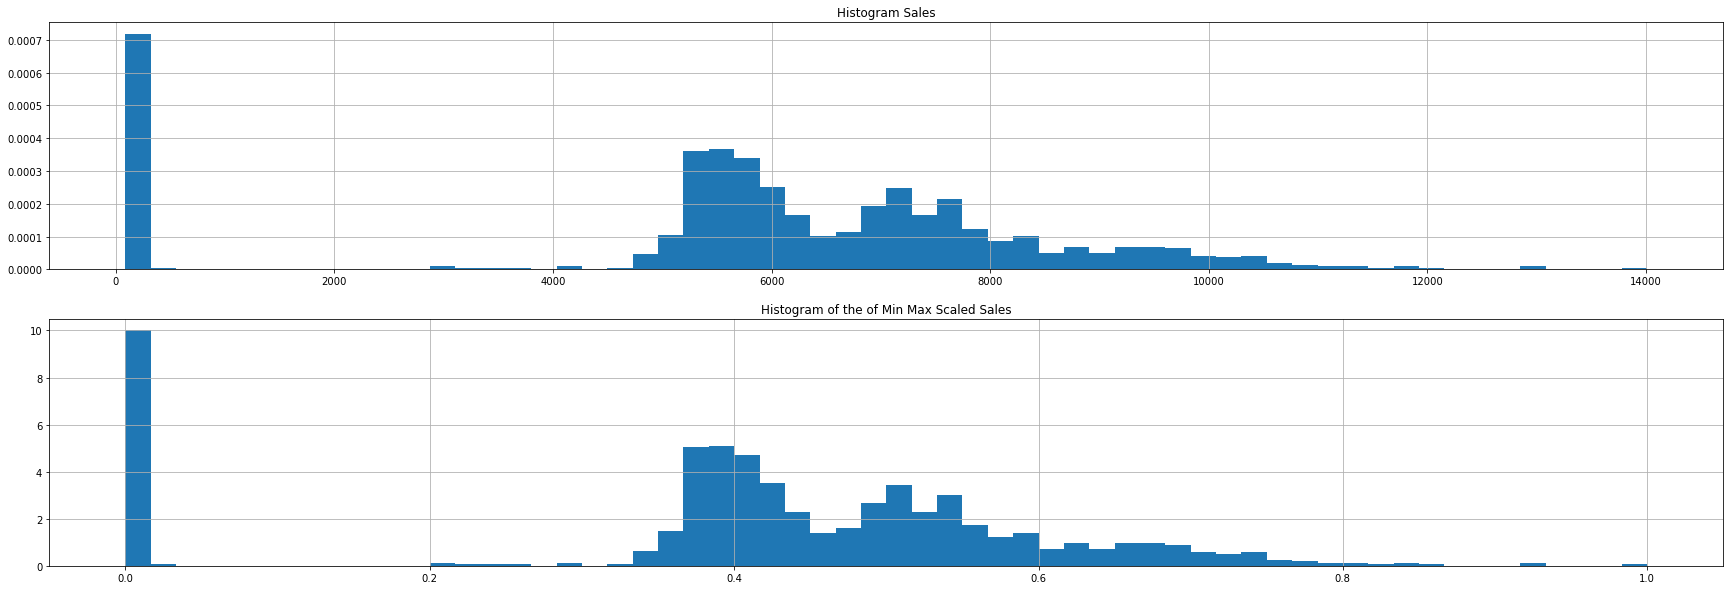

In [31]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(data.Sales, density=True, bins=60)
ax1.title.set_text('Histogram Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(data.DataScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Sales')
ax2.grid(True)
plt.show()

#Unit Root Tests. 

In [32]:
adfResult = adfuller(data.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.650822837207897
p-value: 9.870006549261963e-07


In [33]:
adfResult = adfuller(data.DataScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.650822837207911
p-value: 9.870006549261177e-07


# Removing Stationarity

In [34]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [35]:
dataDif = difference(data.DataScaled.values)

In [36]:
dataDif

0      0.441350
1     -0.038774
2      0.018751
3     -0.044271
4     -0.374057
         ...   
936    0.671214
937   -0.102550
938   -0.039618
939    0.019251
940    0.084431
Length: 941, dtype: float64

# Autocorrelations and Partial Autocorrelations Plots.

In [37]:
acfSalesScaled = acf(data.DataScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

In [38]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

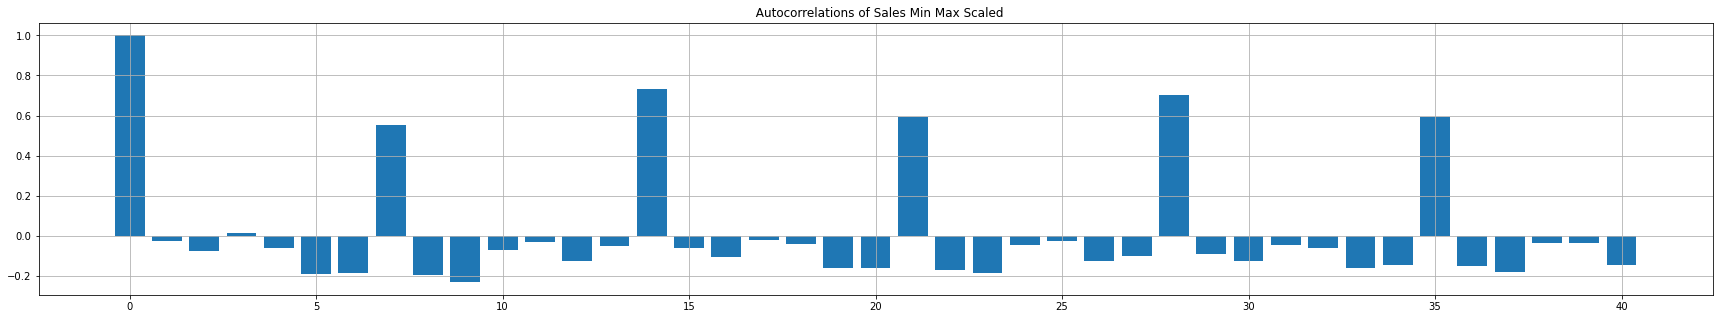

In [39]:
corrPlots(acfSalesScaledNp, '')

In [40]:
pacfSalesScaled = pacf(data.DataScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

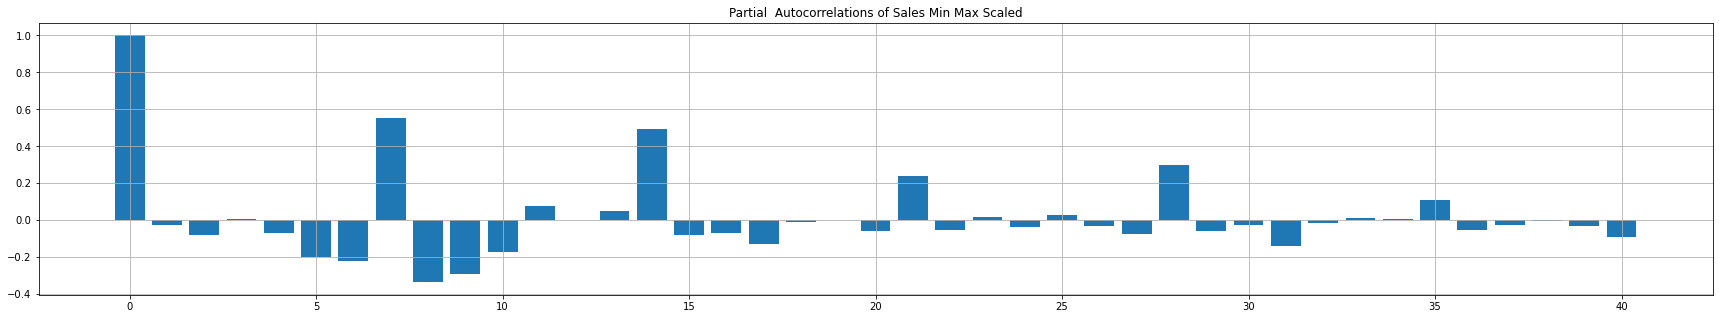

In [41]:
corrPlots(pacfSalesScaledNp, "Partial")

In [42]:
SIZE = len(data.DataScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

# Separating into a Training and Validation Set Fomat to Use Feed into LSTM.

In [43]:
DateTrain = data.index.values[0:BATCH_SIZE]
DateValid = data.index.values[BATCH_SIZE:]
XTrain = data.DataScaled.values[0:BATCH_SIZE].astype('float32')
XValid = data.DataScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [44]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [45]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [46]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [47]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [48]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [49]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [50]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [51]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [52]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

# Define and Estimate the LSTM.

In [53]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 0.1652 - val_loss: 0.1735
Epoch 2/200
1/1 [==============================] - 0s 306ms/step - loss: 0.1598 - val_loss: 0.1680
Epoch 3/200
1/1 [==============================] - 0s 331ms/step - loss: 0.1546 - val_loss: 0.1626
Epoch 4/200
1/1 [==============================] - 0s 394ms/step - loss: 0.1495 - val_loss: 0.1574
Epoch 5/200
1/1 [==============================] - 0s 360ms/step - loss: 0.1446 - val_loss: 0.1523
Epoch 6/200
1/1 [==============================] - 0s 374ms/step - loss: 0.1399 - val_loss: 0.1475
Epoch 7/200
1/1 [==============================] - 0s 300ms/step - loss: 0.1354 - val_loss: 0.1427
Epoch 8/200
1/1 [==============================] - 0s 319ms/step - loss: 0.1310 - val_loss: 0.1382
Epoch 9/200
1/1 [==============================] - 0s 319ms/step - loss: 0.1267 - val_loss: 0.1337
Epoch 10/200
1/1 [==============================] - 0s 347ms/step - loss: 0.1226 - val_loss: 0.1295
Epoch 11/2

1/1 [==============================] - 0s 358ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 84/200
1/1 [==============================] - 0s 370ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 85/200
1/1 [==============================] - 0s 353ms/step - loss: 0.0214 - val_loss: 0.0202
Epoch 86/200
1/1 [==============================] - 0s 371ms/step - loss: 0.0214 - val_loss: 0.0202
Epoch 87/200
1/1 [==============================] - 0s 378ms/step - loss: 0.0214 - val_loss: 0.0202
Epoch 88/200
1/1 [==============================] - 0s 355ms/step - loss: 0.0214 - val_loss: 0.0203
Epoch 89/200
1/1 [==============================] - 0s 325ms/step - loss: 0.0214 - val_loss: 0.0203
Epoch 90/200
1/1 [==============================] - 0s 292ms/step - loss: 0.0214 - val_loss: 0.0203
Epoch 91/200
1/1 [==============================] - 0s 282ms/step - loss: 0.0214 - val_loss: 0.0204
Epoch 92/200
1/1 [==============================] - 0s 382ms/step - loss: 0.0214 - val_loss: 0.0204
Epoch 93/200


1/1 [==============================] - 0s 362ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 165/200
1/1 [==============================] - 0s 365ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 166/200
1/1 [==============================] - 0s 366ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 167/200
1/1 [==============================] - 0s 367ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 168/200
1/1 [==============================] - 0s 371ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 169/200
1/1 [==============================] - 0s 366ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 170/200
1/1 [==============================] - 0s 367ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 171/200
1/1 [==============================] - 0s 362ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 172/200
1/1 [==============================] - 0s 353ms/step - loss: 0.0214 - val_loss: 0.0201
Epoch 173/200
1/1 [==============================] - 0s 321ms/step - loss: 0.0214 - val_loss: 0.0201
Epoc

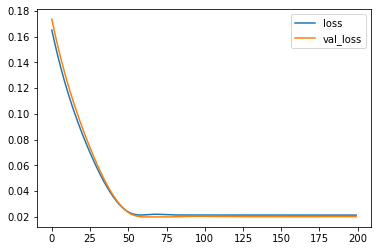

In [56]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

# Forecast the LSTM on the Validation Set and Assess Accuracy.

In [57]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [59]:
Forecast = model_forecast(model, data.DataScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

1/1 [==============================] - 2s 2s/step


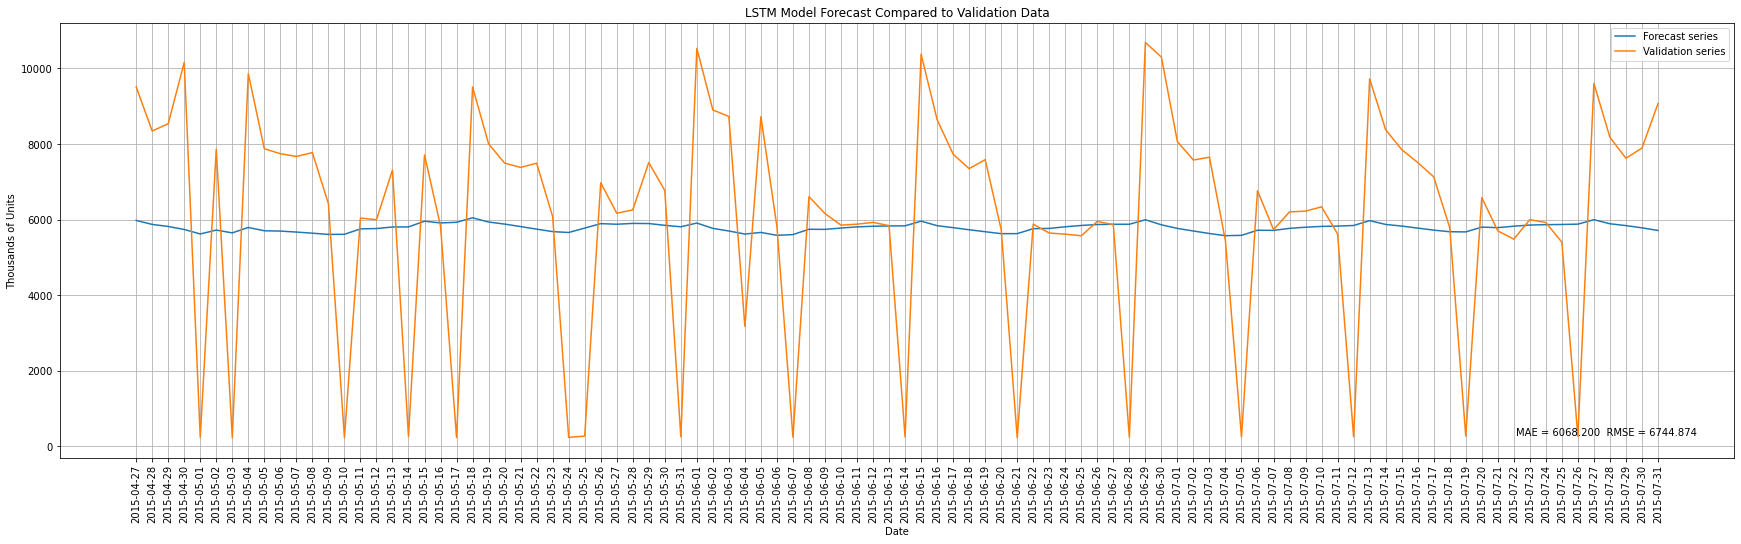

In [60]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [61]:
print(textstr)

MAE = 6068.200  RMSE = 6744.874
